# Retail Trade Sales

In [80]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time
from statistics import mean, stdev
from pytrends.request import TrendReq
from urllib3.exceptions import MaxRetryError

from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import *
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import pearsonr
import warnings

## Functions

### Plot

In [7]:
def plot_df(y, title="", xlabel='Date', ylabel='Value', dpi=100, width = 16, height = 5):
    y.index = pd.to_datetime(y.index)
    plt.figure(figsize=(width,height), dpi=dpi)
    plt.plot(y)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

### Stationary Check for time series

In [13]:
# source link: https://www.statsmodels.org/devel/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

# ADF Test
def adf_test(timeseries):
    #print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    #print(dfoutput)
    if dftest[1] < 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"

# KPSS Test
def kpss_test(timeseries):
    #print("Results of KPSS Test:")
    warnings.filterwarnings("ignore")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    #print(kpss_output)
    if kpsstest[1] > 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"

#Check stationarity    
def check_stationarity(dataframe):
    for i in range(0,dataframe.shape[1]):
        timeseries = dataframe.iloc[:,i]
        adf_result = adf_test(timeseries)
        kpss_result = kpss_test(timeseries)
        if (adf_result == "Series is stationary") and (kpss_result == "Series is stationary"):
            pass
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary")
        elif (adf_result == "Series is stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary, differencing can be used to make it stationary")
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is stationary"):
            print(f"Series {dataframe.columns[i]} is trend stationary, trend needs to be removed")
    print("All other series are stationary")

### Function to fetch data from google trends using pytrends

In [23]:
pytrends = TrendReq(hl='en-US', tz=360, backoff_factor=0.1)

# For categories
def get_trend(keyword=[''], category='0'):
    """ Function for getting trends for selected keywords
        
        arguments: 
        
        Keywords: data type is string: stores list of keywords
        category: data type is string: stores the code for category
        
        returns: google trend data, related queries and related topics as a data frame  
    """
    
    kw_list=keyword
    cat=category
    timeframe='2004-01-01 2022-04-01'
    geo ='CA'
    gprop =''
    
    pytrends.build_payload(kw_list, cat, timeframe, geo, gprop)
    data = pytrends.interest_over_time()
    queries = pytrends.related_queries()
    topics = pytrends.related_topics()
    return data, queries, topics


# For Keywords
def get_trends_for_dict(dict):
    i = 0
    for key, value in dict.items():
        category = key
        kw_lst = set(value)  # removes the repeated keywords
        for keyword in kw_lst:
            data, _, _ = get_trend(keyword=[keyword], category=category)

            # Code to append data for different keywords in data frame
            colname = category+"_"+keyword
            if len(data)==0:
                continue
            else:
                if i == 0:
                    data.rename(columns={keyword: colname}, inplace=True)
                    df = data.drop(columns=['isPartial'])
                else:
                    data.rename(columns={keyword: colname}, inplace=True)
                    data = data.drop(columns=['isPartial'])
                    df = df.join(data)
            i = i+1       
            
    return df

### Functions to make time series stationary

In [31]:
# function to get long term trend
# source link: statsmodels.org/dev/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html

def get_long_term_trend(dataframe, freq='M'):
    dataframe = np.log(dataframe)
    long_term_trend_data = dataframe.copy()
    if freq == 'Q':
        lamb = 1600
    elif freq == 'M':
        lamb = 1600*3**4
    for column_name in dataframe.columns:
        cycle, trend = sm.tsa.filters.hpfilter(dataframe[column_name], lamb)
        long_term_trend_data[column_name] = trend
    return long_term_trend_data


def remove_downward_trend_bias(dataframe, gdp_categoryts_df, freq = 'M'):
    """pass dataframe to remove bias"""
    trend_data = get_long_term_trend(gdp_categoryts_df, freq)
    log_category = np.log(dataframe)
    log_category.replace([np.inf, -np.inf], 0, inplace=True)
    avg_logcategory = log_category.mean()
    pca = PCA(n_components=1)
    pca.fit(trend_data)
    component = pd.DataFrame(pca.fit_transform(trend_data))

    # rescale component
    # transformation source link: https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation
    rescaled_component = avg_logcategory.mean() + (component - component.mean())*(avg_logcategory.std()/component.std())
    
    # remove long term bias
    transformed_data = log_category - rescaled_component.values
    transformed_data.index = pd.to_datetime(transformed_data.index)

    return transformed_data


# function to normalize data

def normalize(dataframe):
    """ function to normalize dataframe"""
    data = dataframe.copy()
    scaler = StandardScaler()
    scaler.fit(dataframe)
    scaled_df = pd.DataFrame(scaler.transform(dataframe))
    scaled_df.index = data.index
    scaled_df.columns = data.columns
    return scaled_df


# function to get first difference (detrending)
def detrend(dataframe):
    return dataframe.diff().dropna()


# funtion to remove seasonality
def remove_seasonality(dataframe):
    data = dataframe.copy()
    # monthly mean
    mean_data = dataframe.groupby(dataframe.index.month).mean()
    for i, d in enumerate(data.index):
        data.iloc[i,:] = mean_data.loc[d.month]
    removed_seaonality_data = dataframe - data
    return removed_seaonality_data


# funtion to remove volatility
def remove_volatility(dataframe):
    data = dataframe.copy()
    # monthly mean
    std_data = dataframe.groupby(dataframe.index.year).std()
    for i, d in enumerate(data.index):
        data.iloc[i,:] = std_data.loc[d.year]
    removed_vol_data = dataframe - data
    return removed_vol_data


### Function to plot lags

In [43]:
def lag_plots(data):
    """plots acf and pacf plots"""
    plot_acf(data)
    plot_pacf(data)
    

### Function for joining predictors

In [45]:
def make_predictors_df(*arg):
    if len(arg) > 1:
        for i in range(0, len(arg)-1):
            arg[i].index = pd.to_datetime(arg[i].index)
            arg[i+1].index = pd.to_datetime(arg[i+1].index)
            predictors_df = pd.merge(arg[i], arg[i+1], left_index=True, right_index=True)
    else:
        arg[0].index = pd.to_datetime(arg[0].index)
        return arg[0]
    return predictors_df

### Function to split data into training and testing set

In [46]:
def ts_train_test_split(response_df, predictors_df, test_size):
    " splits the train and test set and also returns the extra test data of predictors"
    # train test split
    joind_df = pd.merge(response_df, predictors_df, left_index=True, right_index=True)
    train, test = train_test_split(joind_df, test_size=test_size, shuffle=False)
    # extra test data
    extra_test_data = predictors_df.loc[predictors_df.index > joind_df.index[len(joind_df.index)-1], :]
    return train, test, extra_test_data

### Function to plot residuals for plot

In [47]:
# Plot residual errors
def arima_residual_plots(modelfit):
    """ Returns the residual plots of arima model fit when model fit argument is passed"""
    residuals = pd.DataFrame(modelfit.resid)
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.figure(figsize=(12, 5))
    plt.show()

### Function for ARIMA Model

In [48]:
def fit_arima_model(train, dependent_var='GrowthRate', ar_order=1, ma_order=1):
    """ fits arma model to the training data set of GDP"""
    warnings.filterwarnings("ignore")
    model = ARIMA(endog=train[dependent_var],
                  exog=train.loc[:, ~train.columns.isin([dependent_var])],
                  order=(ar_order, 0, ma_order))
    modelfit = model.fit(method='innovations_mle')
    return modelfit

### Function for fitted growth rate

In [49]:
def fitted_growth_plot(modelfit, train):
    fitted_values = pd.DataFrame({'GrowthRate': train['GrowthRate'], 'Fitted Value': modelfit.predict()})
    plot_df(fitted_values, width=12, height=4)

### Function for fitted retail sales value

In [50]:
def fitted_Retail_plot(modelfit,retailsales_final,train):
    """plots the actual and fitted retail trade sales"""
    
    base_retail = retailsales_final['VALUE'][0]
    fitted_values = modelfit.predict()
    fitted_Retail = [0]*(len(fitted_values)+1)
    fitted_Retail[0] = base_retail
    for i, value in enumerate(fitted_values):
        fitted_Retail[i+1] = fitted_Retail[i]*(1 + value)

    
    Train_Actual_Retail = retailsales_final[retailsales_final.index <= train.index[len(train.index)-1]]['VALUE']
    fittedandActual_Retail = pd.DataFrame({'Actual Retail': Train_Actual_Retail, 'Fitted Retail': fitted_Retail})
    plot_df(fittedandActual_Retail)

### Function for Rolling Predictions

In [51]:
def rolling_prediction(train, test, dependent_var='GrowthRate'):
    """ Rolling prediction for test set"""
    train_samples = train.shape[0]
    test_samples = test.shape[0]
    pred_data = pd.DataFrame(columns=None)
    for i in range(train_samples+1, train_samples+test_samples+1):
        modelfit = fit_arima_model(train)

        # Get first row of test set and make prediction
        firstrow_test = np.transpose(pd.DataFrame((test.iloc[0, :])))
        predicted_val = modelfit.forecast(step=1,
                        exog=firstrow_test.loc[:, ~firstrow_test.columns.isin([dependent_var])], dynamic=True)
        predicted_val = pd.DataFrame(predicted_val)
        pred_data = pred_data.append(predicted_val)

        # update training set with one row
        train = pd.concat([train, firstrow_test])

        # Drop first row from test set now
        test = test.drop(f"{firstrow_test.index[0]}")
    return pred_data

### Function for Diagnostic Plot

In [52]:
def diagnostic_check(model):
    "Function to show the diagnostic plots for the model"
    model.plot_diagnostics()

### Function for plotting predicted values

In [54]:
# Plot fitted and predicted Retail

def fitted_and_predicted_retail(modelfit, pred_retailGrowth, retailsales, train, test):
    base_retail = retailsales['VALUE'][0]
    fitted_values = modelfit.predict()
    fitted_Retail = [0]*(len(fitted_values)+1)
    fitted_Retail[0] = base_retail
    for i, value in enumerate(fitted_values):
        fitted_Retail[i+1] = fitted_Retail[i]*(1 + value)
    fitted_Retail_df = pd.DataFrame(fitted_Retail[1:])
    fitted_Retail_df.index = train.index
    
    
    base_retail_test = retailsales[retailsales.index == train.index[-1]]['VALUE'][0]
    predicted_Retail = [0]*(len(pred_retailGrowth.squeeze()))
    actual_Retail = base_retail_test
    for i, value in enumerate(pred_retailGrowth.squeeze()):
        predicted_Retail[i] = actual_Retail*(1 + value)
        actual_Retail = retailsales.loc[test.index[i]][0]
    predicted_Retail_df = pd.DataFrame(predicted_Retail)
    predicted_Retail_df.index = pred_retailGrowth.index
    predicted_Retail_df = pd.concat([retailsales[retailsales.index == train.index[-1]]['VALUE'], predicted_Retail_df])
    
    
    # prediction error calculation
    org = retailsales[retailsales.index >= predicted_Retail_df.index[0]]
    error = 0
    for i in range(0, predicted_Retail_df.shape[0]):
        error = error + (org['VALUE'][i]-predicted_Retail_df[0][i])**2
    pred_error = np.sqrt(error/predicted_Retail_df.shape[0])
    print(f"Prediction error: {pred_error}")

    # Plot actual and fitted Retail Sales
    Actual_RetailSales = retailsales['VALUE'][1:]
    fittedandActual_Retail = pd.DataFrame({'Actual Retail': Actual_RetailSales,
                                        'Fitted Retail': fitted_Retail_df.squeeze(),
                                        'Predicted Retail': predicted_Retail_df.squeeze()
                                       })
    plot_df(fittedandActual_Retail, width=10, height=3)
    return pred_error


### Function for correlation

In [81]:
def select_variables_with_correlation(response, predictors_dataframe, req_corr=0.6):
    """ dataframe is 'categoryts' here"""
    predictors_dataframe.index = pd.to_datetime(predictors_dataframe.index)
    cols = list()
    data = pd.merge(response, predictors_dataframe, left_index=True, right_index=True)

    for i in range(0, data.iloc[:, 2:].shape[1]):
        corr, _ = pearsonr(data['VALUE'], data.iloc[:, i+2])
        if abs(corr) > req_corr:
            cols.append(data.columns[i+2])
    return predictors_dataframe[cols]

### Data Cleaning and Wrangling

In [8]:
# Reading file
retailsales=pd.read_csv('../../data/retailsalesbyIndustry/retailSalesbyIndustry.csv')

# Renaming columns as required
retailsales.rename(columns = {'REF_DATE':'date', 
                                            'GEO':'LOCATION',
                                            'North American Industry Classification System (NAICS)':'INDUSTRY',
                                            'Adjustments':'ADJUSTMENTS'
                                           },inplace = True)

# Filtering columns as needed and extracting required columns
retailsales_filtered=retailsales[(retailsales['LOCATION'] == 'Canada') & 
                 (retailsales['INDUSTRY'] == 'Retail trade [44-45]')&
                 (retailsales['ADJUSTMENTS'] == 'Seasonally adjusted')&
                 (retailsales['date'] >= '2004-01')]
retailsales_final = retailsales_filtered[['date', 'VALUE']].copy()

#Changing data type of date
retailsales_final['date'] =  pd.to_datetime(retailsales_final['date'])
retailsales_final = retailsales_final.set_index('date')
retailsales_final.head()

,VALUE
date,
2004-01-01,27935993.0
2004-02-01,28719948.0
2004-03-01,28689514.0
2004-04-01,28254086.0
2004-05-01,28554094.0


In [9]:
retailsales_initial = retailsales_final.copy()

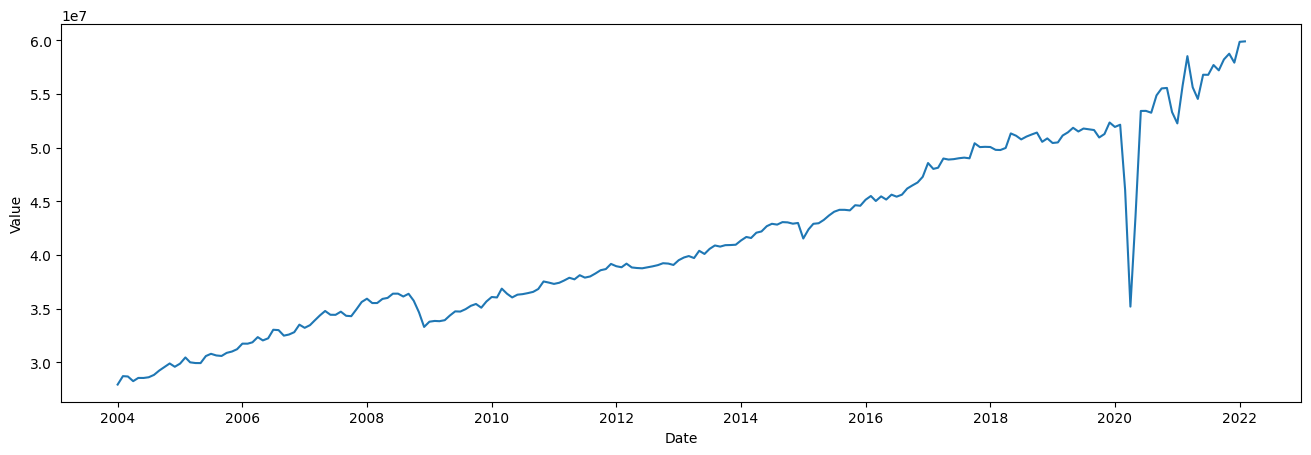

In [10]:
# Plotting retail sales data
plot_df(retailsales_final['VALUE'])

In [11]:
# Adding Growth Rate

retailsales_final['GrowthRate']=retailsales_final['VALUE'].pct_change()
retailsales_final = retailsales_final.dropna()
retailsales_final.head()

,VALUE,GrowthRate
date,,
2004-02-01,28719948.0,0.028063
2004-03-01,28689514.0,-0.001060
2004-04-01,28254086.0,-0.015177
2004-05-01,28554094.0,0.010618
2004-06-01,28550528.0,-0.000125


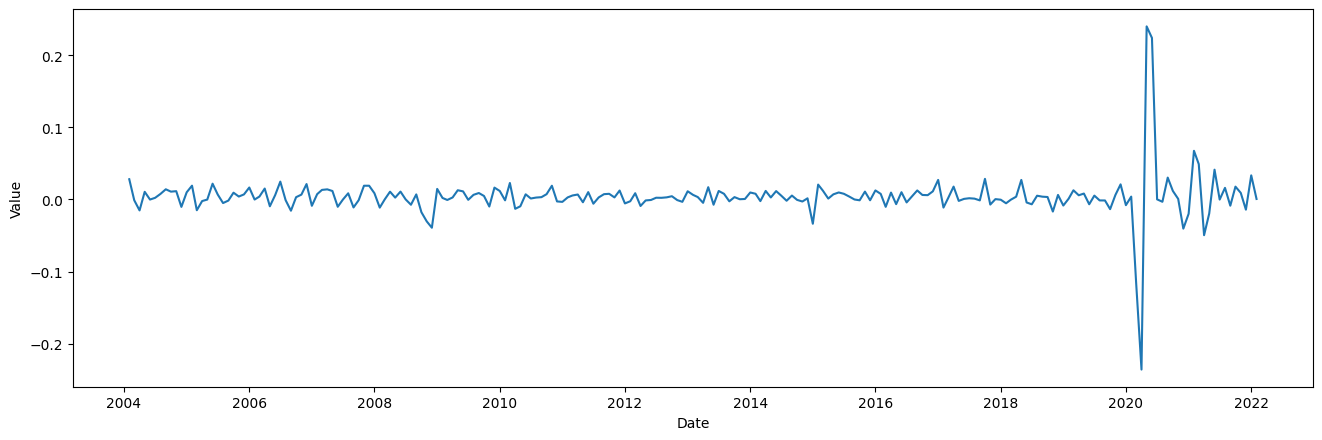

In [12]:
# Plot for growth rate
plot_df(retailsales_final['GrowthRate'])

In [17]:
# Check stationarity
check_stationarity(retailsales_final)

Series VALUE is not stationary
All other series are stationary


## Calculating Google Trends Data

In [18]:
# Reading file for Categories
retailcat=pd.read_csv('../../data/keywords_data/RETAIL_SALES.csv')
retailcatdat = retailcat[['CatNo']].copy()

In [20]:
keywordsDictQuery = dict() #Dictionary for queries
keywordsDictTopic = dict() #Dictionary for topic


for index, row in retailcatdat.iterrows():
    
    #Calling function
    data, queries, topics = get_trend(keyword=[''],category=str(row['CatNo']))
    
    
    #Code to append data for different columns in data frame
    
    if index==0:
        FinalData, queries, topics=get_trend(keyword=[''],category=str(row['CatNo']))
        FinalData.rename(columns = {'':str(row['CatNo'])}, inplace = True)
        FinalData=FinalData.drop(columns=['isPartial'])
    else:
        data, queries, topics=get_trend(keyword=[''],category=str(row['CatNo']))
        data.rename(columns = {'':str(row['CatNo'])}, inplace = True)
        data=data.drop(columns=['isPartial'])
        data = data[str(row['CatNo'])]
        FinalData = FinalData.join(data)
    
    #Code to store queries in a dictionary
    queries = queries['']['top']
    top5_query = pd.DataFrame(queries['query'].copy().head(5))
    top5_query = top5_query['query'].values.tolist()  
    keywordsDictQuery[str(row['CatNo'])] = top5_query
    
    #Code to store topics in a dictionary
    topics = topics['']['top']
    top5_topic = pd.DataFrame(topics['topic_title'].copy().head(5))
    top5_topic = top5_topic['topic_title'].values.tolist()
    keywordsDictTopic[str(row['CatNo'])] = top5_topic

In [21]:
FinalData.head()

,841,47,1190,1191,1140,1213,1013,1214,806,810,...,355,1146,18,1225,270,659,1268,38,844,614
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,49,91,100,51,57,48,86,78,100,90,...,96,38,86,54,90,82,16,91,93,83
2004-02-01,49,89,79,57,57,59,100,91,86,83,...,83,32,82,49,84,89,15,92,100,90
2004-03-01,44,94,64,77,67,64,81,94,89,87,...,90,29,81,50,88,89,23,93,80,86
2004-04-01,47,93,88,93,72,71,90,99,92,90,...,80,32,81,53,79,81,21,94,91,92
2004-05-01,48,94,59,95,73,76,90,90,91,98,...,79,33,80,50,74,81,41,92,91,68


In [22]:
FinalData.to_csv('FinalRetailData.csv')

In [25]:
# For queries
keywords_query = get_trends_for_dict(keywordsDictQuery)
keywords_query.head()

,841_costco,841_superstore,841_sobeys,841_no frills,841_walmart,47_ford,47_toyota,47_dodge,47_honda,47_nissan,...,844_scanner,844_display,844_barcode,844_rfid,844_pos,614_cineplex,614_centre bell,614_ticketmaster,614_vancouver,614_ticket
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,9,15,9,3,13,53,61,56,69,78,...,100,100,44,67,62,19,61,41,64,70
2004-02-01,11,13,5,8,8,50,56,57,66,74,...,51,92,45,100,75,15,60,75,83,70
2004-03-01,11,13,6,4,10,62,67,65,86,81,...,62,82,48,93,73,33,61,57,70,59
2004-04-01,11,13,7,5,13,65,67,64,91,84,...,50,90,44,59,62,31,64,55,63,94
2004-05-01,13,14,7,6,10,59,70,61,91,79,...,37,86,73,80,71,23,26,41,66,45


In [26]:
keywords_query.to_csv('keywords_query_nonstationary.csv')

In [27]:
# For Topics
keywords_topics = get_trends_for_dict(keywordsDictTopic)
keywords_topics

,841_No Frills,841_Flyer,841_Costco,841_Real Canadian Superstore,841_Canada,47_Ford,47_Car,47_Honda,47_Canada,47_Sales,...,38_Ontario,844_Image scanner,844_Point of sale,844_Barcode,844_Canada,614_Vancouver,614_Ticket,614_Ticketmaster,614_Cineplex Entertainment,614_Centre Bell
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,3,3,9,53,33,53,82,69,80,74,...,80,0,48,54,55,66,70,38,0,60
2004-02-01,8,2,11,36,29,50,84,66,85,69,...,67,0,33,61,100,84,70,71,0,59
2004-03-01,3,3,10,30,28,62,87,86,94,74,...,78,0,80,45,31,72,57,57,0,61
2004-04-01,5,3,12,34,30,64,94,91,92,86,...,91,0,48,42,37,65,91,54,0,65
2004-05-01,6,3,14,37,35,58,100,91,97,85,...,84,0,92,75,81,66,46,42,0,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,63,89,87,67,72,70,58,56,62,45,...,52,0,13,41,36,21,27,32,0,18
2022-01-01,63,76,74,57,56,75,62,60,67,49,...,54,7,10,38,53,12,13,13,0,6
2022-02-01,59,73,60,50,51,74,61,60,70,53,...,51,7,9,28,30,20,25,26,0,16


In [28]:
keywords_topics.to_csv('keywords_topics_nonstationary.csv')

In [29]:
#Queries
with open('retail_queries.json', 'w') as fp:
    json.dump(keywordsDictQuery, fp,  indent=4)

In [30]:
#Topics
with open('retail_topics.json', 'w') as fp:
    json.dump(keywordsDictTopic, fp,  indent=4)

### Making Time series stationary

In [32]:
# Reading GDP data for bias
gdp = pd.read_csv('../../src/notebooks/gdp_category_ts.csv', index_col=0)

In [33]:
#temp = remove_downward_trend_bias(FinalData, gdp, freq = 'M')
retail_timeseries = remove_seasonality(detrend(detrend(normalize(FinalData))))

In [34]:
retail_timeseries.to_csv('retailSales_timeseries.csv')

In [35]:
retail_Queries_timeseries = remove_seasonality(detrend(detrend(normalize(keywords_query))))

In [37]:
retail_Queries_timeseries.to_csv('retail_Queries_timeseries.csv')

In [38]:
retail_Topics_timeseries = remove_seasonality(detrend(detrend(normalize(keywords_topics))))

In [39]:
retail_Topics_timeseries.to_csv('retail_Topics_timeseries.csv')

### Modelling

In [40]:
data = pd.read_csv('../../src/notebooks/retailSales_timeseries.csv')
queries = pd.read_csv('../../src/notebooks/retail_Queries_timeseries.csv')
topics = pd.read_csv('../../src/notebooks/retail_Topics_timeseries.csv')

In [41]:
data = data.set_index('date')
queries = queries.set_index('date')
topics = topics.set_index('date')

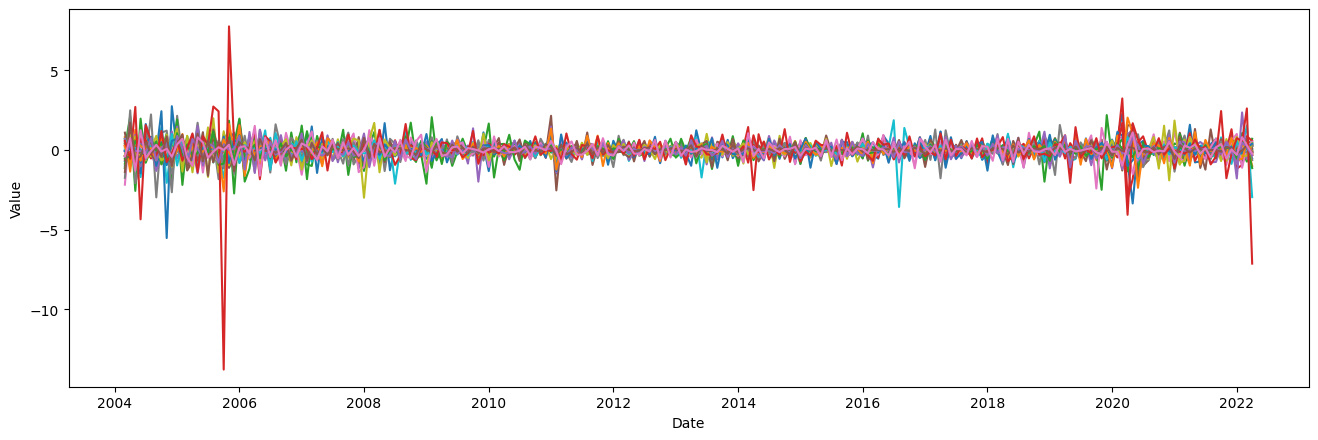

In [42]:
plot_df(data)

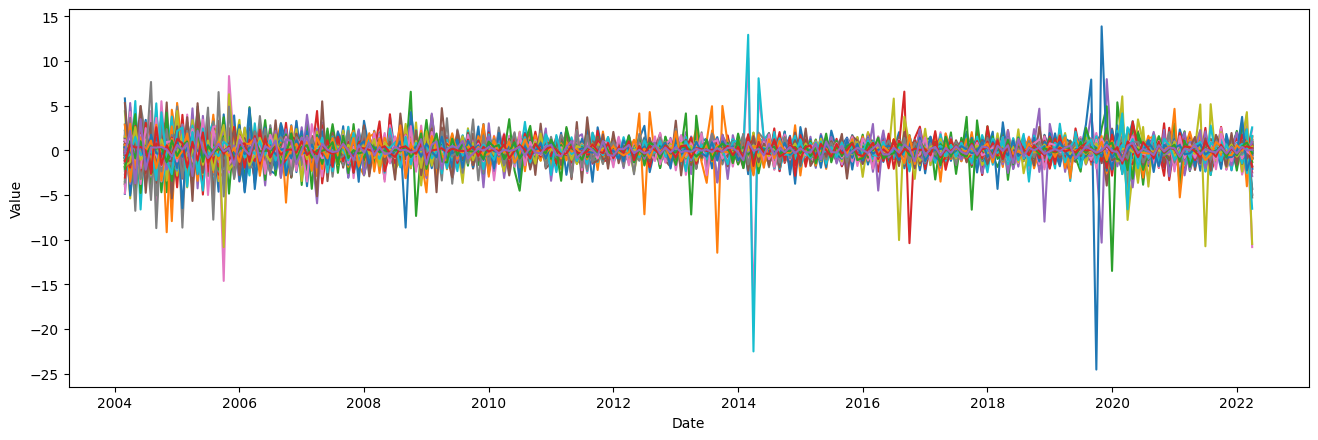

In [56]:
plot_df(queries)

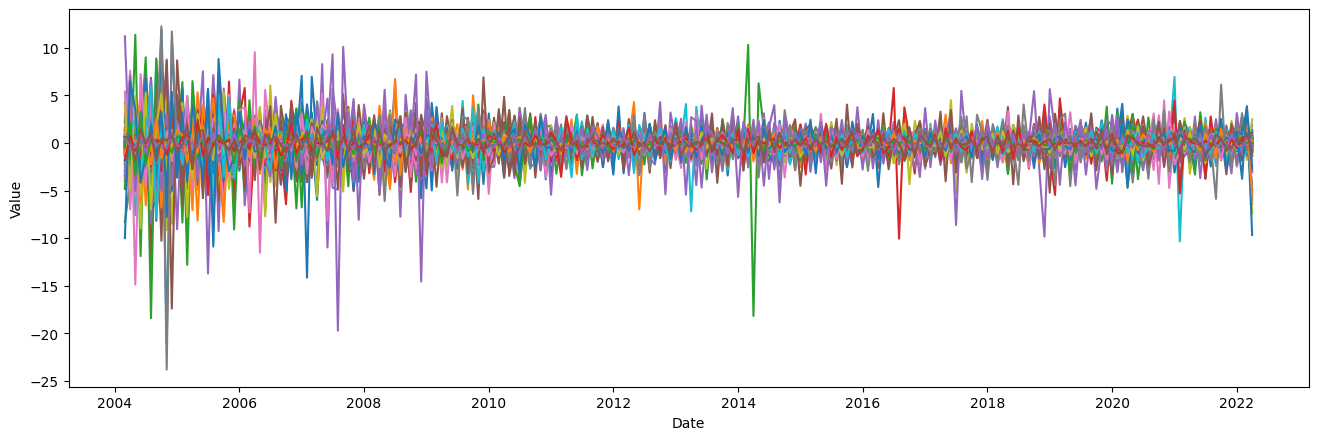

In [57]:
plot_df(topics)

#### Reading original data for model fitting

In [58]:
corrcat = pd.read_csv('../../src/notebooks/FinalRetailData.csv')
corrcat = corrcat.set_index('date')

corrquery = pd.read_csv('../../src/notebooks/keywords_query_nonstationary.csv')
corrquery = corrquery.set_index('date')

corrtopics = pd.read_csv('../../src/notebooks/keywords_topics_nonstationary.csv')
corrtopics = corrtopics.set_index('date')

### Econometric Models

### Model fitting on categories using only DFM using factor = 20

In [59]:
dfm20 = make_predictors_df(corrcat)

In [60]:
#DFM
model_DF = sm.tsa.DynamicFactor(endog=dfm20, k_factors=20, factor_order=1)
res = model_DF.fit()
final = model_DF.fit(res.params)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1177     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81377D+02    |proj g|=  7.90594D-02

At iterate    5    f=  1.74995D+02    |proj g|=  9.56343D-02

At iterate   10    f=  1.66906D+02    |proj g|=  2.00503D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1177     10     13      1     0     0   2.005D-01   1.669D+02
  F =   166.90557320861865     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1177     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66906D+02    |proj g|=  2.00501D-01

At iterate    5    f=  1.63381D+02    |proj g|=  1.78794D-01

At iterate   10    f=  1.58910D+02    |proj g|=  1.59157D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1177     11     13      1     0     0   1.417D-01   1.578D+02
  F =   157.76689292330761     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        


In [62]:
factors = np.transpose(pd.DataFrame(final.factors.filtered))
factors.index = dfm20.index
train_dfm20, test_dfm20, extra_dfm20 = ts_train_test_split(retailsales_final[['GrowthRate']], 
                                                             factors.iloc[:,0:10], 
                                                             test_size=0.3)

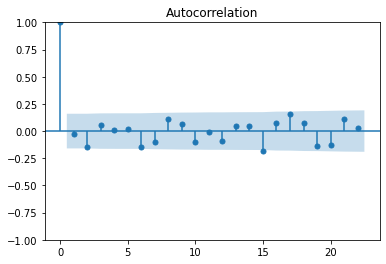

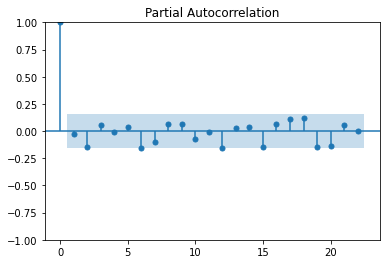

In [63]:
lag_plots(train_dfm20.GrowthRate)

In [64]:
# ARIMA
modelfit_dfm20 = fit_arima_model(train_dfm20)
print(modelfit_dfm20.summary())

                               SARIMAX Results                                
Dep. Variable:             GrowthRate   No. Observations:                  151
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 497.194
Date:                Mon, 23 May 2022   AIC                           -966.388
Time:                        15:48:32   BIC                           -924.146
Sample:                    02-01-2004   HQIC                          -949.227
                         - 08-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0264      0.010     -2.612      0.009      -0.046      -0.007
0              0.0053      0.017      0.308      0.758      -0.028       0.039
1              0.0317      0.036      0.886      0.3

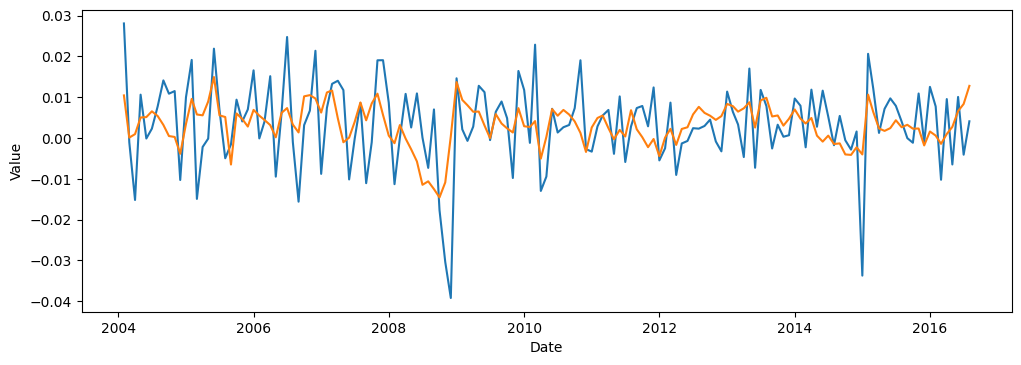

In [65]:
fitted_growth_plot(modelfit_dfm20, train_dfm20)

In [66]:
pred_retailGrowth = rolling_prediction(train_dfm20, test_dfm20)

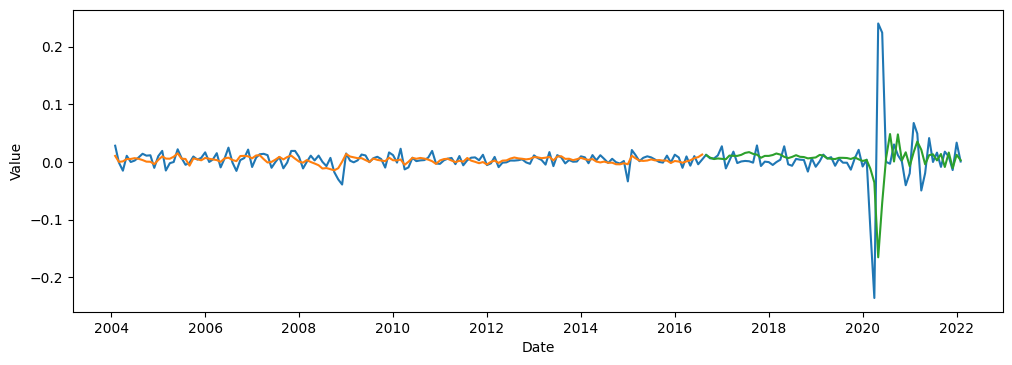

In [67]:
fitted_values = pd.DataFrame({'GrowthRate': retailsales_final['GrowthRate'],
                              'Fitted Value': modelfit_dfm20.predict(),
                              'Predicted Value': pred_retailGrowth.squeeze()})
plot_df(fitted_values, width=12, height=4)

Prediction error: 2885915.8315260904


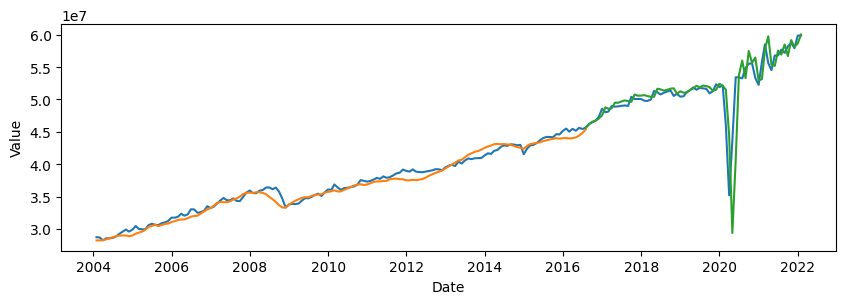

2885915.8315260904

In [68]:
# Predictions
fitted_and_predicted_retail(modelfit_dfm20, pred_retailGrowth, retailsales_initial, train_dfm20, test_dfm20
                           )

### Model fitting on categories using only DFM using factor = 10

In [69]:
dfm10 = make_predictors_df(corrcat)

In [70]:
#DFM
model_DF10 = sm.tsa.DynamicFactor(endog=dfm10, k_factors=10, factor_order=1)
res = model_DF10.fit()
final = model_DF10.fit(res.params)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          507     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75663D+02    |proj g|=  1.59109D-01


 This problem is unconstrained.



At iterate    5    f=  1.57216D+02    |proj g|=  2.61254D-01

At iterate   10    f=  1.51832D+02    |proj g|=  2.51844D-01

At iterate   15    f=  1.47138D+02    |proj g|=  2.07687D-01

At iterate   20    f=  1.43546D+02    |proj g|=  2.24801D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  507     21     30      1     0     0   1.962D-01   1.430D+02
  F =   143.00210993319021     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          507     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43002D+02    |proj g|=  1.96182D-01

At iterate    5    f=  1.40702D+02    |proj g|=  2.42504D-01

At iterate   10    f=  1.38709D+02    |proj g|=  1.46998D-01

At iterate   15    f=  1.37292D+02    |proj g|=  1.06072D-01

At iterate   20    f=  1.36405D+02    |proj g|=  2.08888D-01

At iterate   25    f=  1.35001D+02    |proj g|=  5.33558D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  507     25     30      1     0     0   

In [71]:
factors = np.transpose(pd.DataFrame(final.factors.filtered))
factors.index = dfm10.index
train_dfm10, test_dfm10, extra_dfm10 = ts_train_test_split(retailsales_final[['GrowthRate']], 
                                                             factors, 
                                                             test_size=0.3)

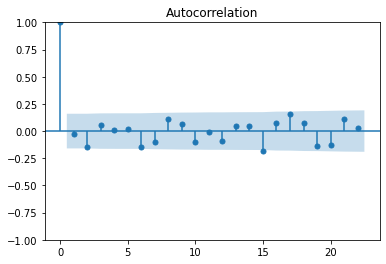

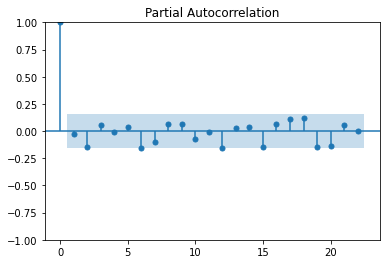

In [72]:
lag_plots(train_dfm10.GrowthRate)

In [73]:
# ARIMA
modelfit_dfm10 = fit_arima_model(train_dfm10)
print(modelfit_dfm10.summary())

                               SARIMAX Results                                
Dep. Variable:             GrowthRate   No. Observations:                  151
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 494.636
Date:                Mon, 23 May 2022   AIC                           -961.273
Time:                        15:55:32   BIC                           -919.031
Sample:                    02-01-2004   HQIC                          -944.112
                         - 08-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0310      0.011     -2.877      0.004      -0.052      -0.010
0              0.0201      0.018      1.120      0.263      -0.015       0.055
1              0.0746      0.038      1.946      0.0

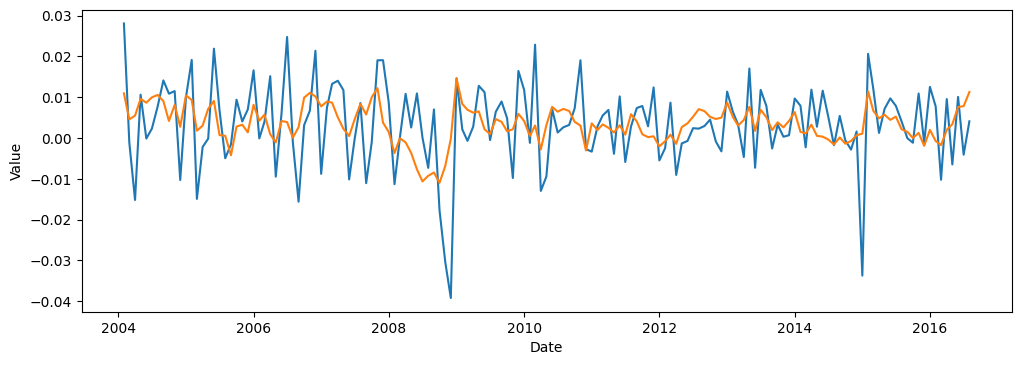

In [74]:
fitted_growth_plot(modelfit_dfm10, train_dfm10)

In [75]:
pred_retailGrowth = rolling_prediction(train_dfm10, test_dfm10)

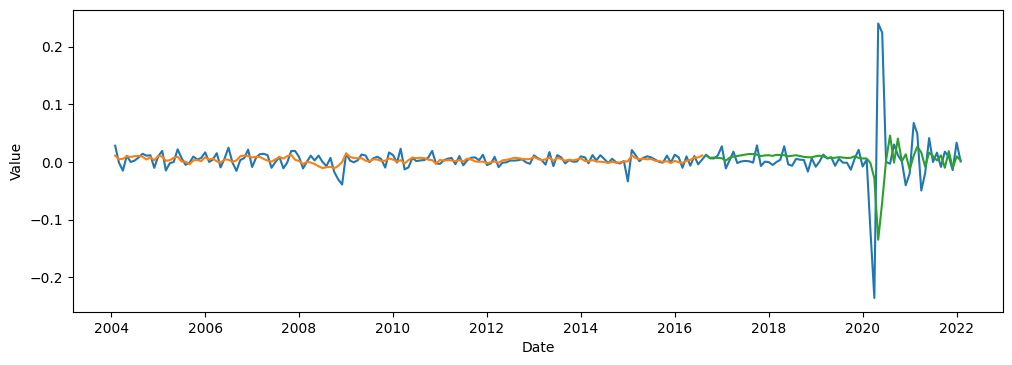

In [76]:
fitted_values = pd.DataFrame({'GrowthRate': retailsales_final['GrowthRate'],
                              'Fitted Value': modelfit_dfm10.predict(),
                              'Predicted Value': pred_retailGrowth.squeeze()})
plot_df(fitted_values, width=12, height=4)

Prediction error: 2828358.5671781353


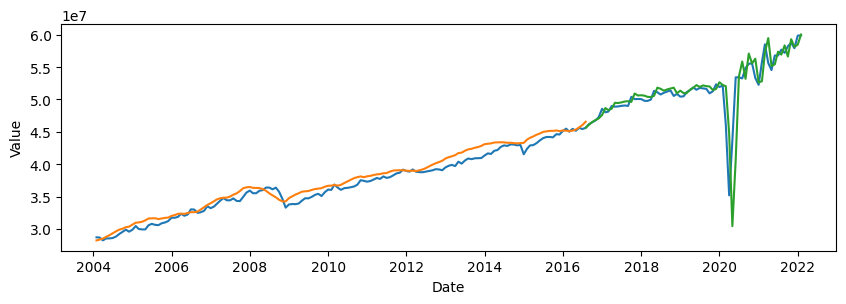

2828358.5671781353

In [77]:
# Predictions
fitted_and_predicted_retail(modelfit_dfm10, pred_retailGrowth, retailsales_initial, train_dfm10, test_dfm10
                           )

### Model Fitting using correlation and not DFM

In [79]:
corrdata = make_predictors_df(corrcat)

In [82]:
cordataframe = select_variables_with_correlation(retailsales_final, corrdata, 0.4)

In [83]:
afterCorr = detrend(detrend(normalize(make_predictors_df(cordataframe))))

In [84]:
check_stationarity(afterCorr)

Series 276 is not stationary, differencing can be used to make it stationary
All other series are stationary


In [85]:
train_corr, test_corr, extra_test_corr = ts_train_test_split(retailsales_final[['GrowthRate']], 
                                                             afterCorr, 
                                                             test_size=0.3)

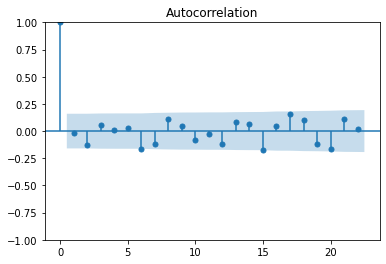

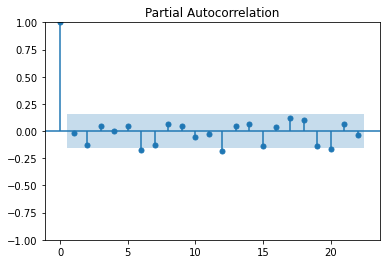

In [86]:
lag_plots(train_corr.GrowthRate)

In [87]:
# ARIMA

modelfit_corr = fit_arima_model(train_corr)
print(modelfit_corr.summary())

                               SARIMAX Results                                
Dep. Variable:             GrowthRate   No. Observations:                  151
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 497.399
Date:                Mon, 23 May 2022   AIC                           -930.799
Time:                        16:05:07   BIC                           -834.246
Sample:                    03-01-2004   HQIC                          -891.574
                         - 09-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.776      0.005       0.001       0.006
47             0.0049      0.006      0.810      0.418      -0.007       0.017
1190          -0.0020      0.001     -1.350      0.1

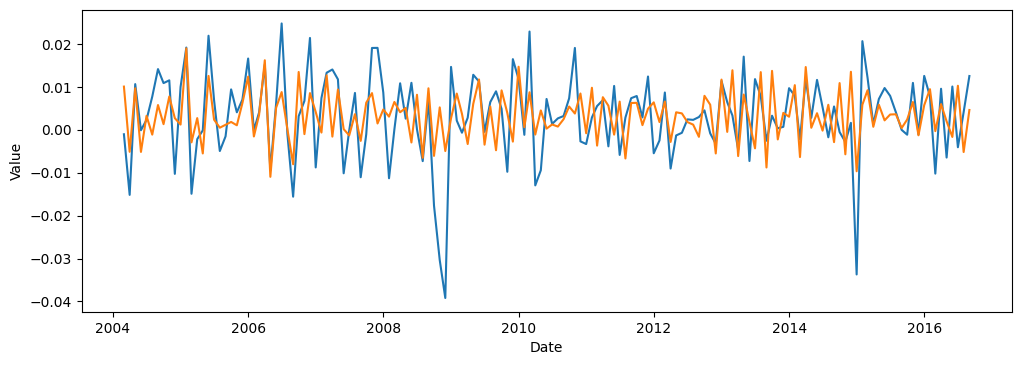

In [88]:
fitted_growth_plot(modelfit_corr, train_corr)

In [89]:
pred_retailGrowth = rolling_prediction(train_corr, test_corr)

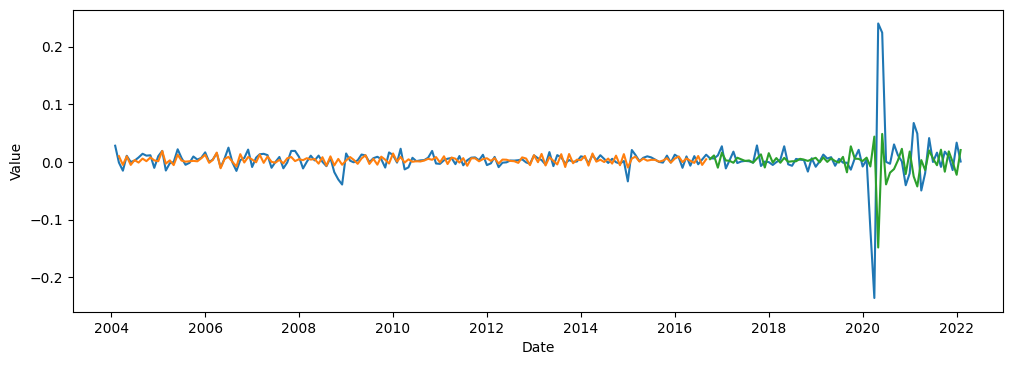

In [90]:
fitted_values = pd.DataFrame({'GrowthRate': retailsales_final['GrowthRate'],
                              'Fitted Value': modelfit_corr.predict(),
                              'Predicted Value': pred_retailGrowth.squeeze()})
plot_df(fitted_values, width=12, height=4)

Prediction error: 2908937.0971795907


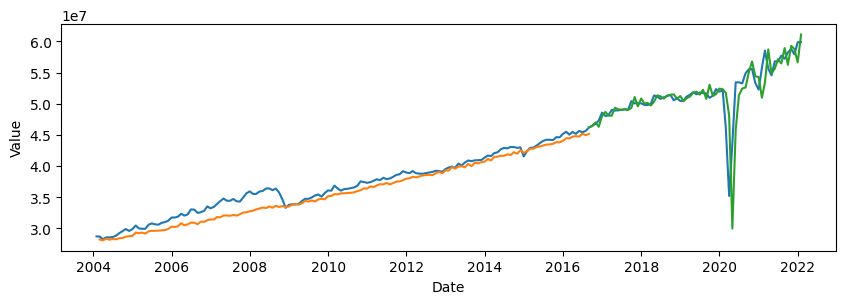

2908937.0971795907

In [91]:
fitted_and_predicted_retail(modelfit_corr, pred_retailGrowth, retailsales_initial, train_corr, test_corr)

### Machine Learning Models